# Нейрокриптография. Древовидные машины четности


Нейрокриптография — раздел криптографии, изучающий применение стохастических алгоритмов, в частности, нейронных сетей, для шифрования и криптоанализа.


### Протокол Диффи-Хеллмана:
Надежность этого протокола сильно зависит от свойств чисел, которые в нем используются, и ученые боятся, что появление квантовых компьютеров, в которых взлом шифра будет гораздо проще, приведет к отказу от такого протокола. Поэтому заранее придумывают алгоритмы обмена ключами, которые бы не были привязаны к свойствам чисел, а основывались бы на других явлениях.

Одним из таких подходов является использования взаимодействующих нейронных сетей, а именно древовидных машин четности, и процесса их синхронизации.

### Древовидные машины четности

ДМЧ — это особый вид многоуровневой нейронной сети прямого распространения.

Она состоит из одного выходного нейрона, K скрытых нейронов и K×N входных нейронов. Входные нейроны принимают двоичные значения:

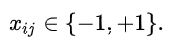

Веса между входными и скрытыми нейронами принимают значения

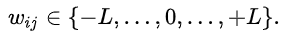

Значение каждого скрытого нейрона есть сумма произведений входного значения и весового коэффициента:

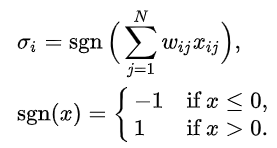

Значение выходного нейрона есть произведение всех скрытых нейронов:

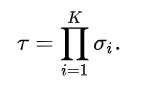

Выходное значение также двоичное.

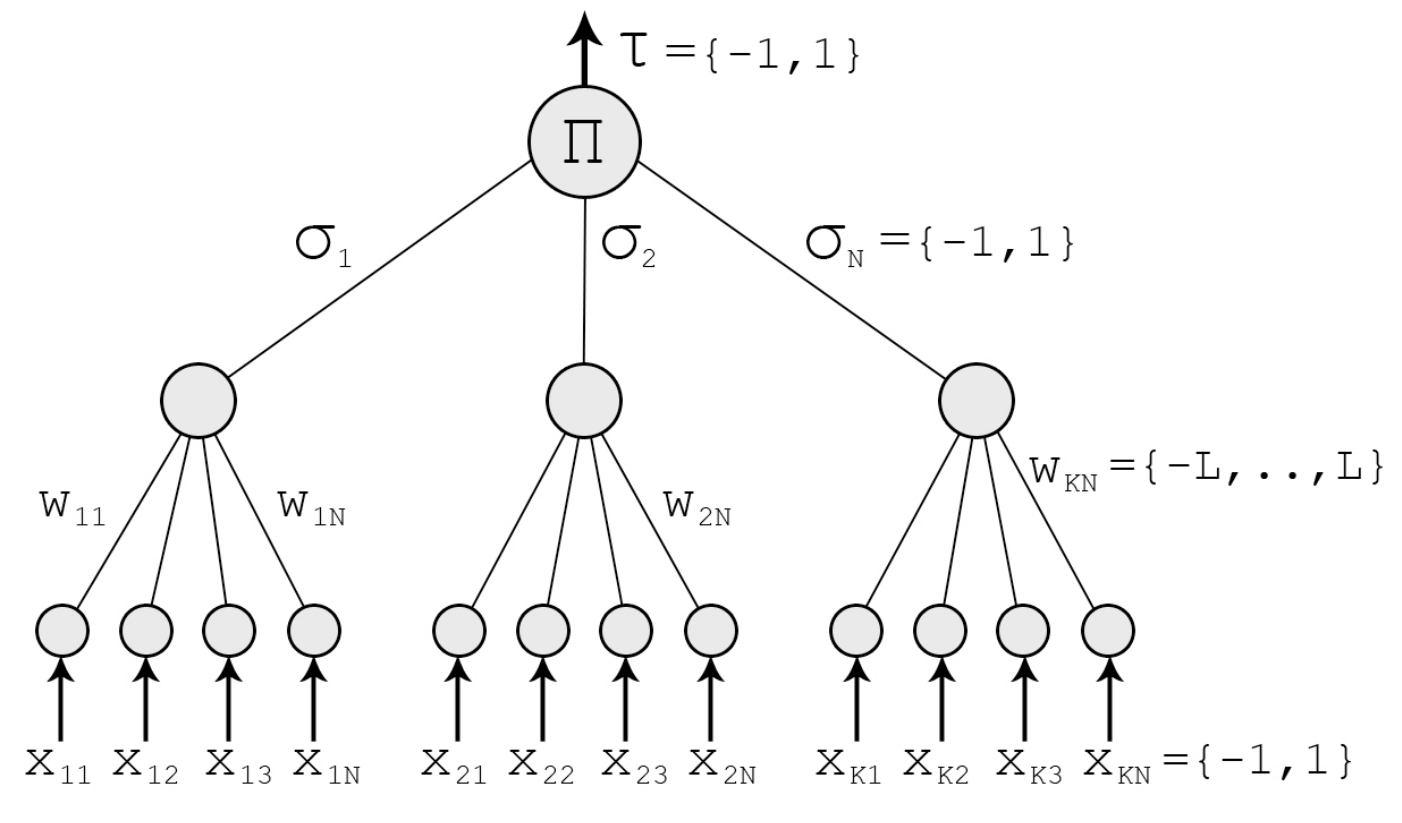

Для обновления весовых коэффициентов используем правило Хебба:
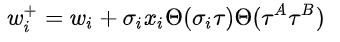

In [7]:
import numpy as np # для работы с массивами 
from matplotlib import pyplot as plt # для рисования

# класс ДМЧ
class TPM:
    def __init__(self, K=10, N=100, L=2): # инициализация
        self.K = K # число нейронов
        self.N = N # число входов каждого нейрона
        self.L = L # дипазон изменения весов
        # случайные целые весовые коэффициенты, удобно представить в виде матрицы
        self.W = np.random.randint(-L, L + 1, [K, N])
        # случайные входы, удобно представить в виде матрицы такого же размера
        self.X = [] #
        self.S = np.zeros([K]) # выходы нейронов первого слоя
        self.T = 0 # выход ДМЧ
        
    def predict(self,X): # расчет выхода ДМЧ
        # X - вход в ДМЧ
        K = self.K # число нейронов
        N = self.N # число входов каждого нейрона
        if X.shape[0] != K: # на всякий случай проверим форму массива
            X = X.reshape([K, N]) # и преобразуем к матрице K*N
        
        S = np.sign(np.sum(X * self.W, axis=1)) # вычислим выходы нейронов
        S[S == 0] = 1 # на случай если сумма равна 0 надо результат заменить на +1
        
        T = np.prod(S) # произведение выходов всех нейронов первого слоя
        
        self.X = X # запишем обратно
        self.S = S 
        self.T = T 
        
        return T # возвратим выход
    
    def update(self,Tb): # обновление весов
        # Tb - выход ДМЧ второго абонента
        W = self.W # веса
        if Tb == self.T: # в случае если выходы обеих машин совпадают
            ind = self.S == Tb # только те нейроны, выходы которых совпадают с выходом машины
            W[ind, :] = W[ind,:] + X[ind,:] * Tb # изменяем по правилу Хебба
            W[W > L] = L # обрезаем, если вышли за диапазон
            W[W < -L] = -L 
            
            self.W = W # сохраняем
            

### rand_x(K,N) 
Генерирует подходящий вход в ДМЧ в виде матрицы размером K на N из дискретного равномерного распределения

In [8]:
def rand_x(K,N): # генерация входа
    return 2 * np.random.randint(0, 1 + 1, [K, N]) - 1 

### sync_score(m1, m2) 
Принимает две ДМЧ m1 и m2 и считает похожесть их весовых коэффициентов так:

1. Считает абсолютное значение разности матриц весов двух ДМЧ
2. Делит это на 2L
3. Находит среднее значение по всем элементам матрицы результата предыдущего пункта
4. Вычитает предыдущий результат из единицы

In [9]:
def sync_score(m1, m2): # доля совпадений весов
    return 1.0 - np.average( # среднее, оно считается по всем элементам
        1.0 * np.abs(m1.W - m2.W) # абсолютное значение разности
        /(2 * m1.L)) # делитель - размер диапазона

Проведём синхронизацию двух ДМЧ Алисы и Боба с K=10, N=20, L=2

[[ 1 -1  1  0 -1  1 -2 -1 -2  2 -2  1 -2 -2  2 -2  2  2 -2  1]
 [-1 -2  2  2  2  1  2  2  1  0 -2  2 -2  1 -1  1  0  1  0  2]
 [ 1 -2  2 -1  0  2 -1  1  0  2 -1 -1 -2  2  2 -2 -2  2 -2  0]
 [ 0  2  2  1  1 -2 -1 -2  0 -2  1  2  1  1  2  1 -2 -2  0 -1]
 [ 0 -1  2 -2 -1 -1  0  2  0 -2 -2  0 -1  0  2 -1  2  1  2  1]
 [ 2 -2 -2  1  2  0  2  0  2  1  1  2 -2  2  1 -2  0 -1  2  1]
 [ 1 -2 -2  0 -1 -2  0  2  0 -1 -1 -2  2  1  2 -2  1  2 -2  2]
 [ 2 -1  0 -2 -2  1  2 -2  0  2 -1 -1  0 -2  0 -2 -2  2  1  2]
 [ 1  0  2 -1 -1 -2 -2  2 -1  0  2  1  2  2  0 -1  0  1  0 -1]
 [ 0 -1  2  0  2  2  2  2  1 -2  0 -2 -1 -1  2  2 -1  0  2  2]]
[[ 1 -1  1  0 -1  1 -2 -1 -2  2 -2  1 -2 -2  2 -2  2  2 -2  1]
 [-1 -2  2  2  2  1  2  2  1  0 -2  2 -2  1 -1  1  0  1  0  2]
 [ 1 -2  2 -1  0  2 -1  1  0  2 -1 -1 -2  2  2 -2 -2  2 -2  0]
 [ 0  2  2  1  1 -2 -1 -2  0 -2  1  2  1  1  2  1 -2 -2  0 -1]
 [ 0 -1  2 -2 -1 -1  0  2  0 -2 -2  0 -1  0  2 -1  2  1  2  1]
 [ 2 -2 -2  1  2  0  2  0  2  1  1  2 -2  2  1 -2  0 -

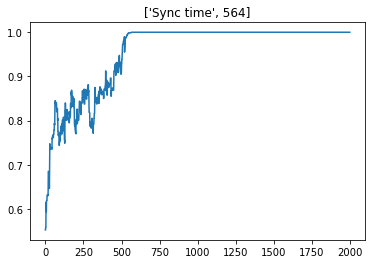

In [12]:
# параметры ДМЧ
K = 10
N = 20
L = 2
Alice = TPM(K=K,N=N,L=L) # Алиса
Bob = TPM(K=K,N=N,L=L) # Боб

M = 2000 # число итераций

score=np.zeros(M) # место для похожести

for i in range(0, M): # итерации синхронизации
    X = rand_x(K, N) # случайный вход

    Ta = Alice.predict(X) # выход Алисы
    Tb = Bob.predict(X) # выход Боба
 
    Alice.update(Tb) # Обновляем Алису
    Bob.update(Ta)   # Обновляем Боба

    score[i] = sync_score(Alice, Bob) # их похожесть

sync_time = np.where(score == 1.0)[0][0] # ищем первую синхронизацию
plt.figure(1) #  
plt.plot(range(0, M), score) # рисуем
plt.title(['Sync time', sync_time]) # заголовок

print(Alice.W) # веса Алисы
print(Bob.W) # веса Боба

Достигнув однажды синхронизации, веса ДМЧ будут одинаковы, значит и выходы обеих ДМЧ и выходы их нейронов будут одинаковы, а значит веса будут изменяться одинаково (т.к. изменяются веса только при совпадении выходов ДМЧ и только у тех нейронов, выход которых совпадает с выходом ДМЧ, а они одинаковы у обеих ДМЧ).

### Хакер

#### Виды атак и надёжность
Для каждой атаки предполагается, что криптоаналитик Е может подслушивать сообщения между А и Б, но не может их изменять

#### Метод грубой силы
Криптоаналитик должен проверить все возможные варианты ключей, то есть все возможные веса wij. Если имеется K скрытых нейронов, K×N входных нейронов и максимальный вес L, то это даёт (2L + 1)KN вариантов. Например, для K = 3, L = 3, N = 100 ≈ 3·10^253 различных ключей. На сегодняшний день такая атака невозможна.

#### Обучение собственной ДМЧ
Пусть у криптоаналитика есть такая же ДМЧ, как и у абонентов. Он хочет её синхронизировать с двумя другими ДМЧ. На каждом шаге возможны три ситуации:
1. Output(A) ≠ Output(B): Абоненты не обновляют веса.
2. Output(A) = Output(B) = Output(E): Все трое обновляют веса.
3. Output(A) = Output(B) ≠ Output(E): А и Б обновляют веса, но Е не может этого сделать. Поэтому он обучается медленнее, чем А и Б синхронизируются.
Таким образом, криптоаналитик может определить ключ лишь с очень малой вероятностью.
Добавим третью ДМЧ - злоумышленника Еву - с теми же параметрами.

[[ 1  0  0  0  2  2  2 -2  2 -2 -2 -1  0  1  1  0  0  2  0  0]
 [ 2 -2  0  1 -2  1  0  0  1  2 -2  0 -1  0  2 -1 -2 -2  2  1]
 [ 1  2 -2  2  0  0 -2  2  2 -2  0 -2  1  2 -1  1 -2  2  1 -2]
 [-1  2  1  0 -2  2  2  2  1  0 -1  0 -2  2  2 -2 -2  0  2 -1]
 [ 2  1  0 -2  1 -1 -1  1  1 -2  0  2 -1  2  0 -2  2  2 -1  2]
 [ 2 -1  2 -2  1 -1  2 -2  0 -1  0  2  0 -2 -1 -2  2  2 -2  2]
 [-1  1 -2 -1 -2 -1 -2  1  0 -2 -1  0  0 -2 -2 -2  2  0  1  2]
 [ 1  2 -2  2  0 -2  2  0  2  0  1  2  1  2  2 -2 -2 -1 -2 -1]
 [ 1 -2 -1 -2  0  2  2  1 -1 -2 -2 -1 -2  2 -1  2  1 -1 -1  2]
 [-2 -2  0  2 -1  0  0  2  1 -2  0  0  2 -1  2 -2 -1 -1 -2  2]]
[[-2 -2  1  1  1 -1 -2  2 -2  1 -2  0  2  2 -2  2 -1  2  0  0]
 [ 2 -2  0  1 -2  1  0  2  1  2 -2 -2 -1  2  2  0 -2 -2  2  2]
 [ 1  1 -2  0  1 -2  1 -2 -2  2  2 -1  2  2  2  0 -1  1  2  2]
 [ 1  2  0  1 -2  2  2  1  0 -1 -2  2 -1  2 -1 -2 -2  0  2 -1]
 [ 2  1  0 -2  2  0 -1  0  0 -2  0  2  0  1  1 -2  1  2 -1  2]
 [ 0  0  2 -1  0  1  2 -2  1  0 -2  2  1 -2  2 -2 -1  

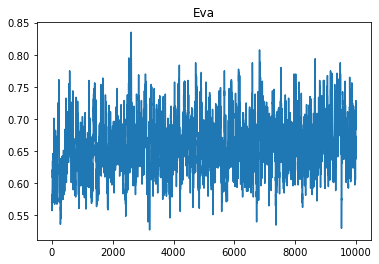

In [11]:
K = 10
N = 20
L = 2
Alice = TPM(K=K,N=N,L=L)
Bob = TPM(K=K,N=N,L=L)
Eva = TPM(K=K,N=N,L=L)# ДМЧ Евы
M = 10000

score = np.zeros(M)
ax = plt.axes();

for i in range(0,M):
    X = rand_x(K,N)

    Ta = Alice.predict(X)
    Tb = Bob.predict(X)
    Te = Eva.predict(X) # Выход ДМЧ Евы

    Alice.update(Tb)
    Bob.update(Ta)
    Eva.update(Ta) # синхронизируем Еву с Алисой
    #Eva.update(Tb) # или с Бобом

    score[i] = sync_score(Alice, Eva)# похожесть Евы и Алисы


plt.figure(1)   
plt.plot(range(0,M),score)
plt.title('Eva')

print(Alice.W)
print(Eva.W)

### Другие атаки
Защищенность обычных криптографических систем можно улучшить, увеличив длину ключа. В нейрокриптографии вместо ключа увеличивается синаптическая длина L. Это увеличивает сложность атаки экспоненциально, в то время как затраты абонентов на дешифрацию растут полиномиально. Таким образом, взлом подобной системы является NP-сложной задачей.

Алексанр Климов, Антон Митягин и Ади Шамир утверждают, что исходный алгоритм нейросинхронизации может быть сломан по крайней мере тремя видами атак: геометрической, вероятностным анализом и генетическими алгоритмами. Хотя данная реализация небезопасна, идеи случайной синхронизации могут привести к абсолютно безопасной схеме.

#### Генетическая атака

Атака строится на создании большой популяции нейронных шифровальных устройств (НШУ) — таких же нейросетей с абсолютно идентичной структурой, что А и Б. В процессе обмена информацией между абонентами происходит либо отсеивание ненужных НШУ, либо наоборот — наращивание потенциально благоприятных для взлома. Формализованный алгоритм выглядит так:

Взломщик инициализует свою машину только с одной НШУ. Веса для него выбираются случайно. Также устанавливается некоторое число М — порог популяции НШУ, которое может себе позволить взломщик.

Затем при обмене информацией между А и Б могут возникнуть три ситуации:

1. Если выходные значения А и Б не равны между собой: Output(A) ≠ Output(B), обновление весов не происходит. Взломщик не трогает свою популяцию.
2. Если Output(A) = Output(B) и число шифровальных устройств у взломщика не превышает порог М, то все НШУ заменяются на репрезентацию из F новых НШУ, каждая из которых получается альтернативной заменой скрытого нейрона на противоположное значение, собственно для этого подбираются новые веса. Затем происходит обучение по правилам Хеббиана.
3. Если Output(A) = Output(B) и число шифровальных устройств у взломщика превышает порог М, то удаляются все те нейромашины, выходное значение которых Output(E) ≠ Output(A).

Данный алгоритм действует только на маленьких нейросетях (N,K<=3) и становится в тупик даже на очень мощных компьютерах при K>=6. Строго говоря, все атаки, предложенные Александром Климовым и Антоном Митягиным основаны на том, что НШУ имеет небольшой размер. На практике же редко применяются шифровальные нейросети с параметрами N<100, K<100, L<10.

#### Защита от квантовых компьютеров

В квантовом компьютере данные хранятся в кубитах. Это позволяет решать более сложные задачи (дискретный логарифм, факторизация) за существенно меньшее время. Поэтому очень важно найти алгоритмы, не основанные на этих проблемах теории чисел.

Нейронный протокол обмена ключей не основан на теории чисел, он основан на различии между однонаправленной и двунаправленной синхронизацией нейронных сетей. Поэтому, подобные протоколы могут ускорить процесс обмена.

Попробуем провести такие вычисления:

K = [5, 10, 20, 50, 100, 500, 1000, 2000, 5000, 10000] при N=10, L=2

N = [5, 10, 20, 50, 100, 500, 1000, 2000, 5000, 10000] при K=10, L=2

L = [1,2,3,4,5,6,7,8] при K=10, N=10

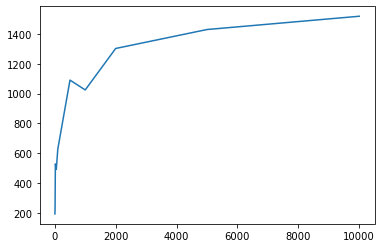

In [19]:
# графики для K
KK = [5, 10, 20, 50, 100, 500, 1000, 2000, 5000, 10000]
N = 10
L = 2

M = 10000 # число итераций
sync_time=[]

for K in KK:
    Alice = TPM(K=K,N=N,L=L) # Алиса
    Bob = TPM(K=K,N=N,L=L) # Боб
    score = 0 
    sync_time.append(np.inf)
    for i in range(0,M): # итерации синхронизации
        X = rand_x(K,N) # случайный вход
        Ta = Alice.predict(X) # выход Алисы
        Tb = Bob.predict(X) # выход Боба
        Alice.update(Tb) # Обновляем Алису
        Bob.update(Ta)   # Обновляем Боба
        score = sync_score(Alice, Bob) # их похожесть
        if score == 1.0: # если синхронизация достигнута
            sync_time[-1] = i;#  записываем номер итерации
            break #  и выходим
            
            
plt.plot(KK,sync_time)

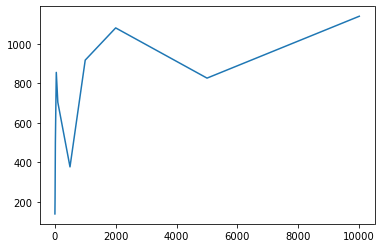

In [14]:
# графики для N
K = 10
NN = [5, 10, 20, 50, 100, 500, 1000, 2000, 5000, 10000]
L = 2

M = 10000 # число итераций
sync_time = []

for N in NN:
    Alice = TPM(K=K,N=N,L=L) # Алиса
    Bob = TPM(K=K,N=N,L=L) # Боб
    score = 0 #
    sync_time.append(np.inf)
    for i in range(0,M): # итерации синхронизации
        X = rand_x(K,N) # случайный вход
        Ta = Alice.predict(X) # выход Алисы
        Tb = Bob.predict(X) # выход Боба
        Alice.update(Tb) # Обновляем Алису
        Bob.update(Ta)   # Обновляем Боба
        score = sync_score(Alice, Bob) # их похожесть
        if score == 1.0:
            sync_time[-1] = i;
            break
            
            
plt.plot(NN,sync_time)

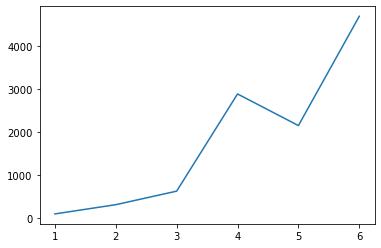

In [20]:
# графики для L
K = 10
N = 10
LL = [1,2,3,4,5,6,7,8]

M = 10000 # число итераций
sync_time = []

for L in LL:
    Alice = TPM(K=K,N=N,L=L) # Алиса
    Bob = TPM(K=K,N=N,L=L) # Боб
    score = 0 
    sync_time.append(np.inf)
    for i in range(0,M): # итерации синхронизации
        X = rand_x(K,N) # случайный вход
        Ta = Alice.predict(X) # выход Алисы
        Tb = Bob.predict(X) # выход Боба
        Alice.update(Tb) # Обновляем Алису
        Bob.update(Ta)   # Обновляем Боба
        score = sync_score(Alice, Bob) # их похожесть
        if score == 1.0:
            sync_time[-1] = i;
            break
            
            
plt.plot(LL,sync_time)

Мы видим, что больше всего на время синхронизации влияет параметр L - диапазон весов. При большем диапазоне веса могут принимать большее число разных значений и тем труднее заставить их быть одинаковыми. Значит выгодно иметь маленькое L. При этом параметры K и N влияют не очень сильно, значит можем генерировать очень длинные ключи, тысячи и десятки тысяч битов.

### Длина секретного ключа в битах
Расчитаем длину секретного ключа в битах для случая K=128,N=128,L=2

In [17]:
def key_len(K,N,L):
    return K*N*np.trunc(np.log2(2*L))

In [18]:
key_len(128,128,2)

32768.0

Каждый вес даст 2 L + 1 возможных значений, для кодировки которых нужно log2(2L+1) бит (в меньшую сторону), а таких весов K * N штук.

Обратите также внимание, что после наступления синхронизации, ДМЧ могут продолжить работу, и будут генерировать все новые и новые веса (ключи), одинаковые у абонентов.

Таким образом нет проблем в генерации множества очень длинных ключей, которые затем можно использовать для шифрования.